In [1]:
!rm -rf "landscape Images"  # Elimina la carpeta anterior
!unzip landscape-image-colorization.zip


unzip:  cannot find or open landscape-image-colorization.zip, landscape-image-colorization.zip.zip or landscape-image-colorization.zip.ZIP.


In [2]:
# 📦 LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import cv2
import os

In [3]:
# Instalar API de Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Sube tu archivo kaggle.json

# Configurar permisos
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar dataset
!kaggle datasets download -d theblackmamba31/landscape-image-colorization
!unzip landscape-image-colorization.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscap

In [4]:
# Configurar Kaggle API (sube tu kaggle.json primero)
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json


In [5]:
# Función para encontrar automáticamente la carpeta de imágenes
def find_image_folder(base_path="/content"):
    for root, dirs, files in os.walk(base_path):
        if "color" in root.lower() and any(f.lower().endswith(('.jpg', '.png')) for f in files):
            return root
    return None

In [6]:
# =========================
# 2. 📸 EXTRACCIÓN DE ATRIBUTOS (20+)
# =========================
import cv2
import numpy as np
import pandas as pd
from skimage import filters, measure
from tqdm import tqdm

def extract_features(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Normalizar imagen a 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w = img.shape[:2]
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 📊 Estadísticas básicas y de color
        features = {
            'image_id': os.path.basename(image_path),
            'width': w,
            'height': h,
            'aspect_ratio': round(w / h, 2),
            'file_size_kb': round(os.path.getsize(image_path) / 1024, 2),
            'red_mean': np.mean(img[:, :, 0]),
            'green_mean': np.mean(img[:, :, 1]),
            'blue_mean': np.mean(img[:, :, 2]),
            'hue_mean': np.mean(img_hsv[:, :, 0]),
            'saturation_mean': np.mean(img_hsv[:, :, 1]),
            'value_mean': np.mean(img_hsv[:, :, 2]),
            'lab_l_mean': np.mean(img_lab[:, :, 0]),
            'lab_a_mean': np.mean(img_lab[:, :, 1]),
            'lab_b_mean': np.mean(img_lab[:, :, 2]),
            'std_dev': np.std(img_gray),
            'entropy': measure.shannon_entropy(img_gray),
            'edge_density': np.mean(filters.sobel(img_gray)),
            'is_landscape': int(w > h),
            'brightness': np.mean(img_gray),
            'contrast': img_gray.std(),
            'center_red': np.mean(img[100:124, 100:124, 0])  # zona central
        }

        return features

    except Exception as e:
        print(f"⚠️ Error en {image_path}: {str(e)}")
        return None


In [28]:
import os
from tqdm import tqdm  # Para mostrar una barra de progreso

# Define la carpeta donde están las imágenes (ajusta según tu caso)
color_folder = "landscape Images/color/"  # o "landscape Images/gray/"

# Verifica que la carpeta exista
if not os.path.exists(color_folder):
    raise FileNotFoundError(f"La carpeta {color_folder} no existe.")

# Procesar imágenes (ejemplo con tqdm para barra de progreso)
features_list = []
for img_file in tqdm(os.listdir(color_folder)):  # Procesa solo 100 imágenes
    path = os.path.join(color_folder, img_file)
    features = extract_features(path)  # Asegúrate de que esta función esté definida
    features_list.append(features)

100%|██████████| 7129/7129 [00:42<00:00, 166.33it/s]


In [29]:
# 💡 Filtrar datos válidos (eliminar los None)
features_list = [f for f in features_list if f is not None]
print(f"Cantidad de imágenes procesadas correctamente: {len(features_list)}")


Cantidad de imágenes procesadas correctamente: 7129


In [30]:
# No sobreescribas features_list, ya la generaste antes con datos reales
df = pd.DataFrame([f for f in features_list if f is not None])  # Limpieza de datos nulos


In [31]:
# Normalizá los valores (opcional pero recomendable)
from sklearn.preprocessing import MinMaxScaler
cols = ["red_mean", "green_mean", "blue_mean", "hue_mean"]

scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

# Gráfica corregida
import plotly.express as px

fig = px.parallel_coordinates(
    df.head(50),  # o df completo si querés
    dimensions=cols,
    color="hue_mean"
)
fig.show()


✅ REGRESIÓN MÚLTIPLE COMPLETA

👉 Coeficientes:
width: 0.0
height: -0.0
aspect_ratio: -0.0
file_size_kb: 0.0001
red_mean: 64.497
green_mean: 121.2879
blue_mean: 25.4863
hue_mean: -0.0088
saturation_mean: -0.0
value_mean: 0.0001
lab_l_mean: -0.0
lab_a_mean: -0.0003
lab_b_mean: -0.0002
std_dev: 0.0
entropy: -0.0012
edge_density: -0.0203
is_landscape: 0.0
contrast: 0.0
center_red: -0.0

Intercepto: 12.7315
MSE: 0.0001
R² Score: 1.0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.



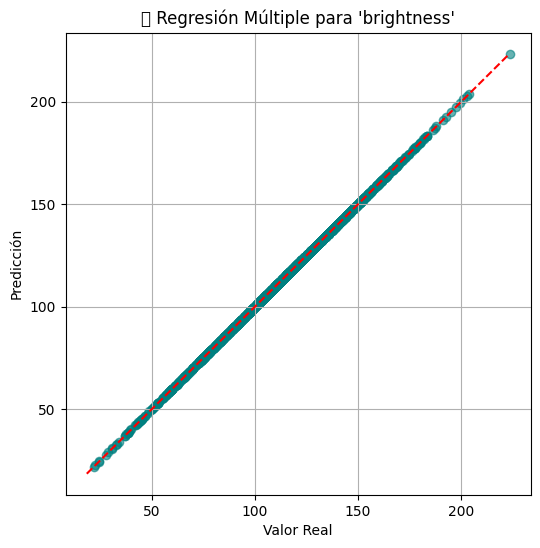

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 🎯 Variable objetivo (puedes cambiarla por 'brightness', 'contrast', etc.)
target = 'brightness'

# 🎯 Atributos: todos menos 'image_id' y el objetivo
features = [col for col in df.columns if col not in ['image_id', target]]

# 📊 X e y
X = df[features]
y = df[target]

# 📁 División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 📈 Entrenamiento del modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 🔍 Predicción
y_pred = modelo.predict(X_test)

# 📋 Evaluación
print("✅ REGRESIÓN MÚLTIPLE COMPLETA\n")
print("👉 Coeficientes:")
for f, c in zip(features, modelo.coef_):
    print(f"{f}: {round(c, 4)}")

print("\nIntercepto:", round(modelo.intercept_, 4))
print("MSE:", round(mean_squared_error(y_test, y_pred), 4))
print("R² Score:", round(r2_score(y_test, y_pred), 4))

# 📉 Visualización de predicción real vs predicha
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="teal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title(f"🔮 Regresión Múltiple para '{target}'")
plt.grid(True)
plt.show()


In [33]:
!pip install opencv-python numpy matplotlib scikit-learn

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

# Función para extraer paleta de colores de una imagen
def extract_color_palette(image_path, n_colors=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)

    palette = kmeans.cluster_centers_.astype(int)
    return palette

# Función para calcular el error (inercia) y la precisión (silhouette score)
def evaluate_palette(image_path, n_colors=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(pixels, kmeans.labels_)

    return inertia, silhouette

# Directorio de imágenes (ajusta según tu estructura)
image_dir = "landscape Images/gray/"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')][:100]  # Procesar solo 100 imágenes para ejemplo

# Número de colores en la paleta
n_colors = 5

# Listas para almacenar métricas
inertias = []
silhouettes = []

# Procesar imágenes y calcular métricas
for image_path in image_files:
    inertia, silhouette = evaluate_palette(image_path, n_colors)
    inertias.append(inertia)
    silhouettes.append(silhouette)

# Gráfica de la función de costo (inercia)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(inertias)), inertias, marker='o', linestyle='-', color='b')
plt.title('Función de Costo (Inercia) por Imagen')
plt.xlabel('Número de Imagen')
plt.ylabel('Inercia')
plt.grid(True)

# Gráfica de la precisión (silhouette score)
plt.subplot(1, 2, 2)
plt.plot(range(len(silhouettes)), silhouettes, marker='o', linestyle='-', color='r')
plt.title('Precisión (Silhouette Score) por Imagen')
plt.xlabel('Número de Imagen')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# 🔍 1. REGRESIÓN LINEAL MÚLTIPLE
# ===============================

# Selección de atributos predictivos (X) y variable objetivo (y)
X = df[["red_mean", "green_mean", "blue_mean"]]
y = df["brightness"]

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)

print("🔎 Resultados de la regresión:")
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# ================================
# 🎨 2. PALETA DE COLORES (KMEANS)
# ================================

def extract_palette(image_path, k=5):
    img = cv2.imread(image_path)
    if img is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))  # a una lista de píxeles

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(img)

    colors = kmeans.cluster_centers_.astype(int)

    # Mostrar paleta
    plt.figure(figsize=(8, 2))
    for i, color in enumerate(colors):
        plt.subplot(1, k, i + 1)
        plt.imshow([[color / 255]])
        plt.axis("off")
    plt.suptitle("🎨 Paleta de colores dominante")
    plt.show()

    return colors

# Reemplaza con una ruta válida de imagen de tu dataset
color_folder = "/content/Images/color"
sample_img = os.path.join(color_folder, os.listdir(color_folder)[0])
extract_palette(sample_img)

🔎 Resultados de la regresión:
Coeficientes: [0.29909209 0.5870655  0.11399037]
Intercepto: -0.01581201789022657
MSE: 0.00011989021222345423
R²: 0.9999999203137784


FileNotFoundError: [Errno 2] No such file or directory: '/content/Images/color'